# **Challenge: Create an RFM metrics analysis model**

An e-commerce company is trying to better understand the behavior of its customers in order to personalize its marketing campaigns. To do this, the company has made available a csv database containing data on customers, products and store transactions carried out between 2010 and 2011. The data provided contains purchase transaction information from an e-commerce store in 38 countries and territories, with more than 4,000 unique customers and more than 540,000 transactions.

Based on this data, customers will be grouped into clusters based on their purchasing behavior using the K-Means algorithm. This will make it possible to identify patterns and characteristics in common between customers, such as:

* Customers who buy the same products;
* Customers who make the same number of purchases;
* Customers who spend more money on their purchases.

From these clusters, insights should be generated so that the company can better segment its customer base and personalize its marketing campaigns, targeting promotions and offers to customers based on their purchasing behavior.


**About the data**

The data is also available at  https://www.kaggle.com/datasets/carrie1/ecommerce-data


**Please note:** the dates are in MM/DD/YYYY HH:mm:ss format; there is null data that needs to be processed before the analysis can be carried out; although the identification codes are numerical, the model cannot consider them as numerical quantities.

**Objectives**

* Develop a clustering model capable of grouping customers according to their purchasing behavior, taking the RFM into account.
* Analyze the clusters obtained to identify the customer profile, such as patterns and characteristics in common to determine their purchasing behavior.
* Use graphs and visualizations to aid analysis.
* Document each stage, justifying the choices made and reporting the insights gained, as well as recommendations for future action, so that the company can put them into practice.

## **DEVELOPMENT STEPS**

# Exploratory Data Analysis (EDA)

In [ ]:
# Importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import datetime as dt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Importing dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Mês 8/Desafio 7/data.csv"
df = pd.read_csv(path, encoding='latin1')
df_backup = df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df = df_backup.copy()

Checking dataset size:

In [ ]:
numLinhas = df.shape[0]
numCols = df.shape[1]
print("Número de linhas: {}".format(numLinhas)) #number of rows
print("Número de colunas: {}".format(numCols)) #number of columns

Número de linhas: 541909
Número de colunas: 8


Checking the type of variables and the presence of null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We found that the features 'InvoiceNo', 'InvoiceDate', 'UnitPrice' and 'CustomerID' have inappropriate types, which should be Int, DateTime, Float and Int, respectively.

In [ ]:
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'], errors='coerce')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = "%m/%d/%Y %H:%M")
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors = "coerce")
df['CustomerID'] = pd.to_numeric(df['CustomerID'])

Checking null values:

In [ ]:
df.isna().sum()

,0
InvoiceNo,9291
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


We have verified that we have null values in the InvoiceNo', 'Description' and 'CustomerID' features.

In [ ]:
cols = ('InvoiceNo', 'Description', 'CustomerID')
for col in cols:
  print("Número de valores nulos na coluna {}: {:.2f} %".format(col, df[col].isna().sum()*100/numLinhas)) # Number of null values in Column X

Número de valores nulos na coluna InvoiceNo: 1.71 %
Número de valores nulos na coluna Description: 0.27 %
Número de valores nulos na coluna CustomerID: 24.93 %


We can see that almost 25% of the data in the 'CustomerID' feature is empty, which is quite high, while 'InvoiceNo' and 'Description' have relatively few null values.

Checking duplicated registers:

In [ ]:
numDuplicados = df.duplicated().sum()
print("Total de registros duplicados: {}".format(numDuplicados)) # Number of duplicated registers:
print("% de duplicados: {:.2f} %".format(numDuplicados*100/numLinhas)) # % of duplicated registers:

Total de registros duplicados: 5268
% de duplicados: 0.97 %


We found that we have a total of 5,390 duplicate records (less than 1%), which will need to be removed later so as not to bias the analysis.

In [ ]:
  df.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
count,532618.000000,541909.000000,541909,541909.000000,406829.000000
mean,559965.752027,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,536365.000000,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,547906.000000,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,560688.000000,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,571841.000000,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,581587.000000,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,13428.417281,218.081158,NaN,96.759853,1713.600303


For a descriptive analysis, the 'CustomerID' feature will not be analyzed, since its data only deals with the identification of a customer. However, analyzing the 'Quantity' and 'UnitPrice' features, we found inconsistencies in their data, such as the presence of negative quantities, which is not possible. The 'Quantity' and 'UnitPrice' features also have a lot of outliers, since in the 75% quartile, they have values equal to 10 and 4.13, and their maximum values are 80,995 and 38,970.00, respectively.

Let's take a closer look at the data distribution in a Box Plot graph, excluding the features 'InvoiceNo' and 'CustomerID':

<Axes: >

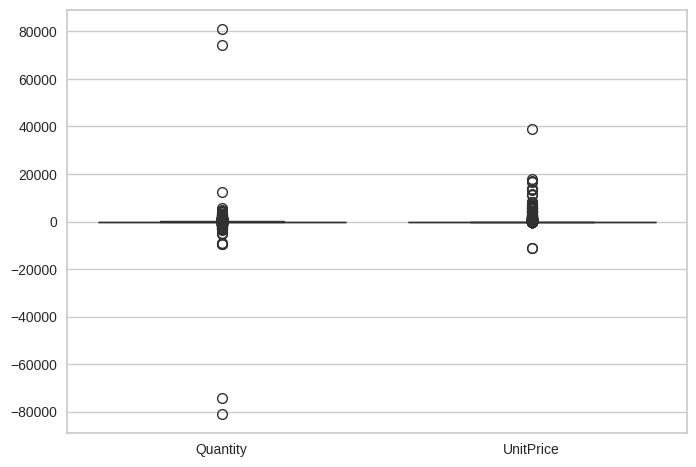

In [ ]:
sns.boxplot(data = df[['Quantity', 'UnitPrice']])

We have seen the presence of a few outliers, which will not be deleted at this stage as they require further analysis. We will also have to adopt a strategy for the negative quantities present.

Now we'll look at the other columns to see how many unique values they have

In [ ]:
df['StockCode'].nunique()

4070

The 'StockCode' column has 4070 unique values, i.e. my dataset has 4070 different products.

The 10 best-selling products are:

In [ ]:
df_mais_vendidos = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
df_mais_vendidos.head(10)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
JUMBO BAG RED RETROSPOT,47363
ASSORTED COLOUR BIRD ORNAMENT,36381
POPCORN HOLDER,36334
PACK OF 72 RETROSPOT CAKE CASES,36039
WHITE HANGING HEART T-LIGHT HOLDER,35317
RABBIT NIGHT LIGHT,30680
MINI PAINT SET VINTAGE,26437
PACK OF 12 LONDON TISSUES,26315


We will now look at the items with the largest quantities sold:

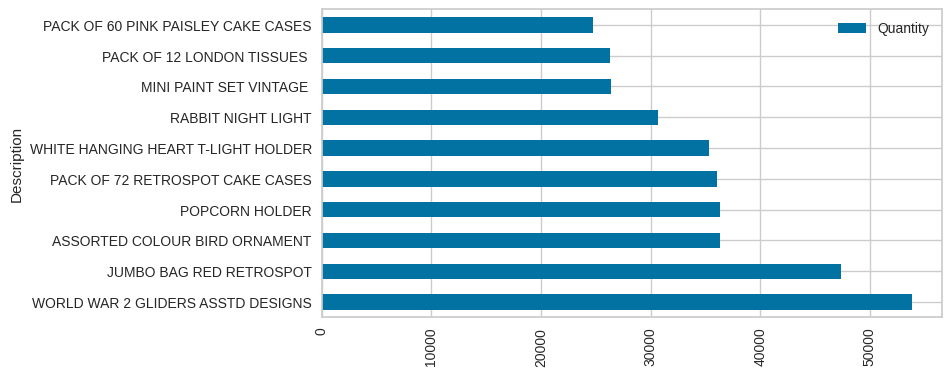

In [ ]:
df_mais_vendidos.reset_index().loc[0:9].plot(kind='barh', x='Description', y='Quantity', figsize=(8, 4))
plt.xticks(rotation=90)
plt.show()


Now looking at the 'Country' feature

In [ ]:
df['Country'].nunique()

38

Our dataset contains sales made to 38 different countries.

In [ ]:
df_countries = df.groupby('Country')['Country'].count().sort_values(ascending=False)
df_countries = pd.DataFrame(df_countries)
df_countries['Percentage'] = df_countries['Country']*100/df.shape[0]
df_countries.head(10)

,Country,Percentage
Country,,
United Kingdom,495478,91.431956
Germany,9495,1.752139
France,8557,1.579047
EIRE,8196,1.512431
Spain,2533,0.467422
Netherlands,2371,0.437527
Belgium,2069,0.381798
Switzerland,2002,0.369435
Portugal,1519,0.280305


There are 38 different countries in the feature, with the UK predominating.

Now let's check the total monthly sales, where we analyze by the single occurrence of 'InvoicesNo', without considering values or quantities:

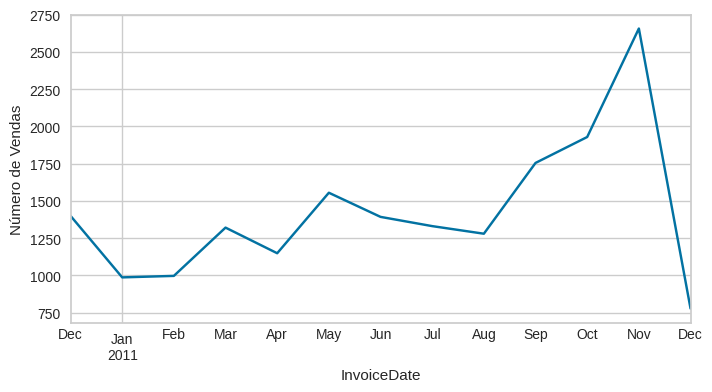

In [ ]:
df_vendas = df.set_index('InvoiceDate').sort_index()
df_vendas = df_vendas['InvoiceNo'].resample('M').nunique()
df_vendas.plot(kind='line', figsize=(8, 4))
plt.ylabel('Número de Vendas') # Number of Sales
plt.show()

The graph shows an evolution in the number of sales made in the period. Until August 2011 it remained stable, with a big increase from then until November 2011. From that month onwards, it showed a considerable drop, which is justified given that the period under consideration ends on 12/09/2011.

# Data Preparation

Let's start by deleting data in the features 'UnitPrice' and 'Quantity' with negative values:

In [ ]:
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]

Deleting duplicated registers:

In [ ]:
df.drop_duplicates(inplace=True)

As we have a large number of null values in the 'CustomerID' feature, the absence of this data makes the rest of the record worthless, as it is not possible to make inferences about a given customer. Therefore, records with null values in these features will be deleted.

In [ ]:
df.dropna(subset = 'CustomerID', inplace=True)
df.isna().sum().sum()

0

Agora não temos nulos

In [ ]:
df.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692,392692.000000,392692.000000
mean,560590.875047,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865
min,536365.000000,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,549234.000000,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,561874.000000,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,572061.000000,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,581587.000000,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,13087.063759,180.492832,NaN,22.241836,1713.539549


Let's create a column to calculate the total value per product, i.e. the quantity per unit value, which will be needed to calculate the M metric:

In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365.0,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


When analyzing the features of the dataset provided, it can be seen that:
* The 'CustomerID' feature is very important for calculating the RFM metrics, since these metrics will be used as a basis and calculated per customer.
* In order to calculate Recency (R), the 'InvoiceDate' feature is essential for extracting the date of each customer's last purchase and calculating the number of days that have passed since then;
* For calculating Frequency (F), the 'InvoiceNo' feature, through its unique values, will give us how many purchases each customer made in the period under consideration; and
* For calculating Monetary Value (M), which here will be calculated as the customer's average ticket in the period under consideration, taking into account all the purchases made. To calculate this, we use the 'TotalPrice' feature, which in turn is calculated using the 'Quantity' and 'UnitPrice' features;

This means that the 'StockCode', 'Description' and 'Country' features are not relevant to the calculation of RFM metrics, although they may be relevant to other analyses, which are beyond the scope of this Challenge.

**Calculation of RFM Metrics**

First, let's remember the maximum and minimum dates of the 'InvoiceDate' feature:

In [ ]:
minDate, maxDate = df['InvoiceDate'].min(), df['InvoiceDate'].max()
print("Data mínima: {}".format(minDate)) # Earliest Date
print("Data máxima: {}".format(maxDate)) # Latest Date

Data mínima: 2010-12-01 08:26:00
Data máxima: 2011-12-09 12:50:00


As the dataset is kind of old, let's simulate that the base date for calculating recency will be 12/12/2011:

In [ ]:
refDate = pd.Timestamp('2011-12-12')
refDate

Timestamp('2011-12-12 00:00:00')

Now let's find the RFM metrics per customer by grouping the data in a new dataset:

In [ ]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (refDate - x.max()).days), #calculates the difference in days between the base date and the date of the last purchase
      F = ('InvoiceNo', 'nunique'),   # calculates the number of purchases made in the period
      M = ('TotalPrice', 'mean')  # calculates the monetary value, i.e. the customer's average ticket considering all their purchases in the period
  )
)
df_rfm.head()

,R,F,M
CustomerID,,,
12346.0,327,1,77183.600000
12347.0,4,7,23.681319
12348.0,77,4,57.975484
12349.0,20,1,24.076027
12350.0,312,1,19.670588


Let's analyze the df_rfm dataset using a boxplot graph

<Axes: >

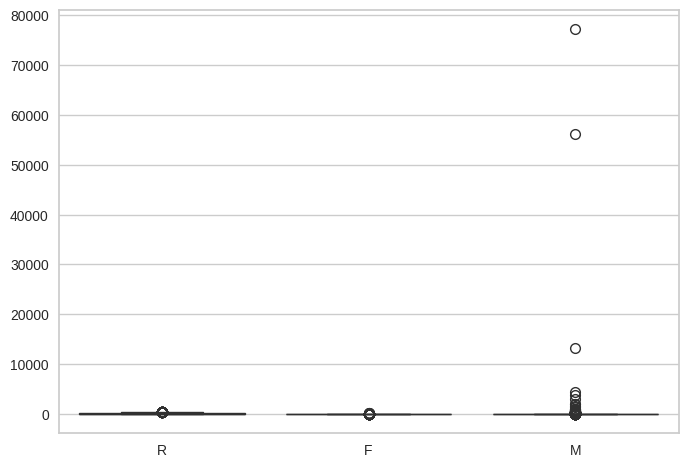

In [ ]:
sns.boxplot(data = df_rfm)

At this level of scale, there are no outliers in R and F. However, M is noteworthy for having exorbitant values of over 20,000. Let's exclude these outliers using a filter for M < 20,000.

In [ ]:
df_rfm = df_rfm[df_rfm['M']<20_000]

Now let's normalize our df_rfm dataset using the PowerTransformer function for a better visualization:

<Axes: >

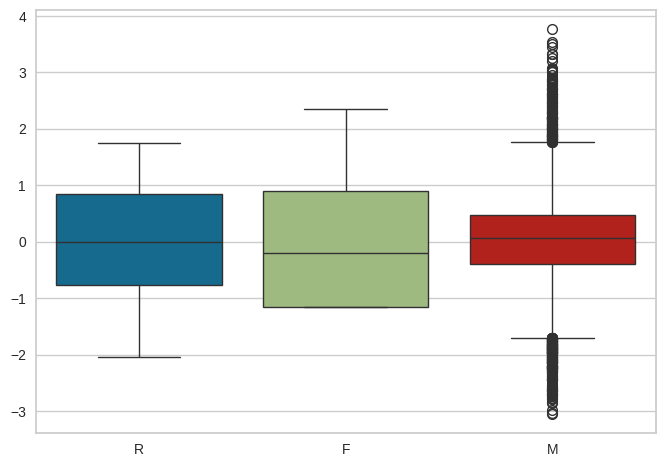

In [ ]:
scaler = PowerTransformer()
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns = df_rfm.columns, index = df_rfm.index)
sns.boxplot(data=df_rfm_scaled)

We now see that there are no outliers in R and F after normalization. In M, the values are within almost 4 standard deviations. We will exclude the values above the 95% quartile, which will be treated here as outliers:


In [ ]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,92.242851,3.608625,23.739758
std,95.498840,3.358778,21.186639
min,2.000000,1.000000,2.136970
25%,19.000000,1.000000,12.390365
50%,52.000000,2.000000,17.747784
75%,143.250000,5.000000,24.863607
max,313.000000,13.000000,92.900000


<Axes: >

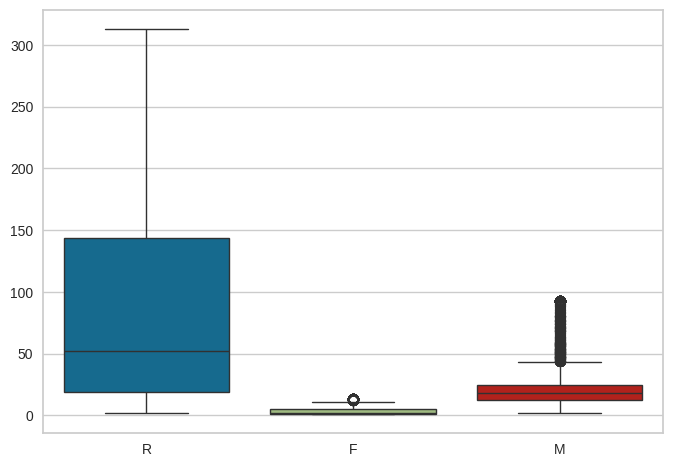

In [ ]:
sns.boxplot(data = df_rfm_clip)

Now that we've clipped the data, we'll proceed once again to normalize it using the PowerTransform already instantiated as a scaler:

In [ ]:
df_rfm_clip_scaled = scaler.fit_transform(df_rfm_clip)
df_rfm_clip_scaled = pd.DataFrame(df_rfm_clip_scaled, columns = df_rfm.columns, index = df_rfm.index)

Finally, we plot its Boxplot graph:

<Axes: >

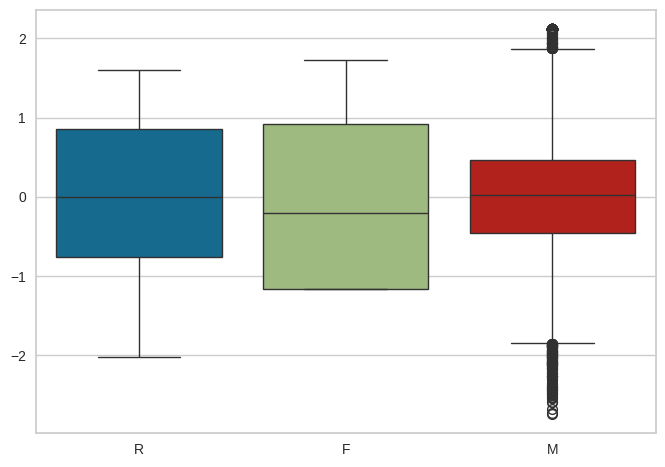

In [ ]:
sns.boxplot(data=df_rfm_clip_scaled)

Here we'll check the distribution of our RFM metrics using histograms to better understand the customers' purchasing profile:

<Axes: xlabel='M', ylabel='Count'>

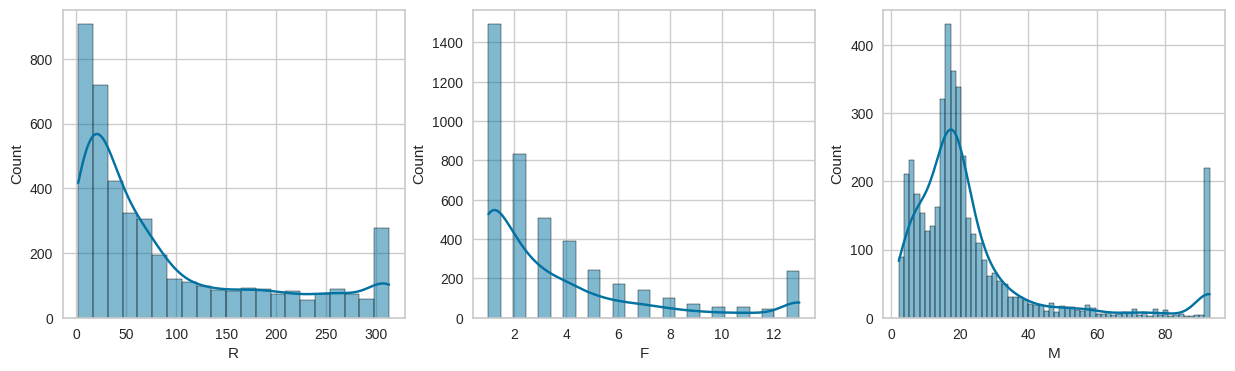

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 4))
sns.histplot(data=df_rfm_clip, x='R', kde=True, ax=ax[0])
sns.histplot(data=df_rfm_clip, x='F', kde=True, ax=ax[1])
sns.histplot(data=df_rfm_clip, x='M', kde=True, ax=ax[2])

Looking at Recency, we can see that a considerable proportion of customers have made purchases in the last 30 days, after which the value drops and remains stable for longer periods. At the end of the histogram, there is a jump in the number of customers who have made purchases in the last 310 days, indicating the presence of customers who rarely buy or who made a purchase a long time ago and never bought again.

As for Frequency, a high number of customers made very few purchases in the period and an even higher number made between 15 and 25 purchases in the whole period. From then on, with greater frequency, fewer and fewer customers made purchases. The last bar of the histogram shows that a large number of customers also made more than 90 purchases in the period, which would be slightly less than one purchase every four days. This phenomenon merits further investigation in order to better analyze what type of customer this is.

In Monetary Value (M), we see a high number of low ticket customers, and as the average ticket increases, we see a greater number of customers who fall into this situation, reaching a peak between 15-25. From then on, the higher the price, the lower the number of customers, until for average tickets over 90, there is a jump in the number of customers.

# Modelling

The challenge gives us the chance to choose one of four clustering algorithms. They are: K-Means, DBSCAN, Hierarchical Clustering or MeanShift.

For our modeling, we will use K-Means. It was chosen because it is a simple algorithm, easy to implement and efficient for handling large amounts of data, as is the case with our dataset, which can be difficult to process in Google Collaboratory.

To apply K-Means, we need to estimate an optimal number of clusters (k), since it is an unsupervised algorithm, and for this we have the Silhouette Score metric. Although it gives us a relationship between the number of clusters K x inertia x score, there is nothing to stop us from implementing the algorithm with a different number k, if it suits our purpose. It's worth noting here that the higher the Silhouette Score, the better, more defined and non-overlapping the k clusters are.

In [ ]:
cluster_silhouette_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_result = {'k': k}
  cluster_result['inertia'] = model.inertia_
  cluster_result['silhouette_score'] = silhouette_score(X, labels)
  cluster_silhouette_results.append(cluster_result)

pd.DataFrame(cluster_silhouette_results).set_index('k').style.background_gradient()

,inertia,silhouette_score
k,,
2,8087.689273,0.341700
3,6371.860884,0.322998
4,5473.344983,0.297115
5,4689.349787,0.285976
6,4043.807860,0.296258
7,3476.495808,0.308064
8,3082.797897,0.313039
9,2830.906261,0.310811
10,2581.457472,0.318716


From the Silhouette Score metric, we see that we have a lower error for k=5. We then proceeded to implement K-Means:

In [ ]:
kmeans = KMeans(5)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

# Analysis of the clusters

Plotting the clusters obtained by color in 3D:

In [ ]:
px.scatter_3d(df_rfm_clip_scaled, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

We notice that, according to the Elbow Method, we have 5 clusters delimited to 5 regions in three-dimensional space, identified by a color scheme, where:

* Cluster 0 is represented in red;
* Cluster 1 is represented in lilac;
* Cluster 2 is represented in orange;
* Cluster 3 is represented in blue; and
* Cluster 4 is represented in green;

The clusters show a well-defined region, but with considerable occurrences of overlapping clusters, which is justified by the Silhouette Score metric of around 0.29 (far from 1, which is the best case). The clusters are predominantly found near the vertices of the cube formed by the data set, and from there, they spread towards the center of the cube, but without occupying it, due to the occurrence of cluster 4, green, which occupies a region without vertices, but with an edge, tending towards low values for Recency and reasonable values for the other metrics.

There is a practically unfilled region in the cube in our 3D region, showing that there are few clients with significant values for all three metrics.

Calculating the location of the centroids of each cluster:

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)
centers

,R,F,M
0,-0.877579,1.147755,0.349866
1,0.671981,-0.443579,1.563413
2,-0.193488,-0.462305,0.048490
3,-0.424623,0.171687,-1.521648
4,1.233544,-0.843588,-0.247828


Let's plot the graphs from the centroid of each cluster, to identify the characteristics of the customers who belong to each one:

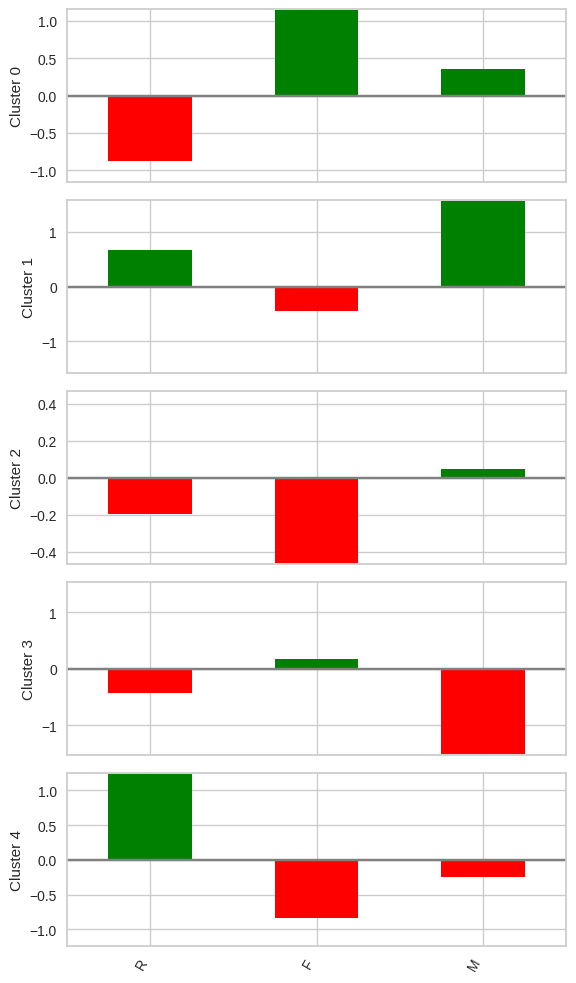

In [ ]:
# Adapted from the book "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=5, figsize=(6,10), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Thus, from the centroids we can classify each cluster, and consequently identify the main patterns among the customers contained in them. So we have:


**Cluster 0:** customers with high frequency, average ticket and low recency, i.e. they are always buying;

**Cluster 1:** customers with high recency, very low frequency and low ticket, who are probably churn customers;

**Cluster 2:** high monetary value customers, i.e. high average ticket, with low recency and low recency. These are customers who buy large sums of money, but sporadically;

**Cluster 3:** customers with a very low average ticket, with some frequency and low recency. These are occasional customers who have recently bought products of very low value; and

**Cluster 4:** customers with an average ticket, extremely low frequency and low recency, indicating that they are customers who have made one purchase or another recently. They are probably new customers.

Let's now analyze our non-normalized metrics dataset to confirm these clusters:

In [ ]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3,4
R,23.740164,145.086134,50.107921,44.665630,225.544073
F,7.422951,2.084034,1.864356,3.634526,1.397163
M,27.490663,64.261510,18.924652,5.956509,16.073527


As we have described and can confirm in the table above, we have three clusters that are characterized by having high metrics: cluster 0, 1 and 2, which have the highest Frequency, Recency and Monetary Value metrics, respectively. Cluster 2, in addition to having the highest monetary value, hasn't bought for a long time and has a low frequency. The customer in cluster 1 is the one who bought a long time ago and never made a new purchase, generally becoming a churn. Cluster 0 customers are recurring customers who make purchases with a not-so-high ticket.

Cluster 3 customers do not stand out in any metric. Cluster 4 customers are probably new customers, given their low frequency, low ticket and low recency.

# Interpretation of Results

**Cluster 0**

Cluster 0 customers tend to be quite frequent, make purchases of a medium value and have only been buying for a short time. Although they don't have a high monetary value, the high frequency with which they buy makes these customers compensate for this deficiency and make them strategic. A marketing strategy based on recommendation systems would also be interesting, so that customers continue to make new purchases. In recommendation systems, we could start suggesting higher-value items mixed with items with similar prices to those they already buy, in order to increase their average ticket. Allied to this, a follow-up system could be a fundamental strategy for understanding their needs, although it would increase the e-commerce company's costs.

**Cluster 1**

They are churn customers. As they have little history, little is known about their behavior, so that a strategy can be devised to attract them again. It would be up to the stakeholders to analyze whether it's worth trying to convert this churn customer, because as well as having a low ticket, it would represent an increase in the company's operating costs. It's probably not worth investing in attracting this customer segment.

**Cluster 2**

Customers in this cluster are valuable to the company. Although they are not as frequent, the high value of their average ticket compensates for the period without purchases. Like the customers in cluster 0, this is also a strategic and valuable customer. Therefore, the e-commerce company must also make efforts to retain and consolidate them, as well as adopting marketing strategies to get them to buy more often. It is necessary to know their profile, as they may be a legal entity that makes purchases in order to replenish its physical stock, or individual customers who focus on high value-added items, and for these reasons go a considerable time without making new purchases.


**Cluster 3**

They are ordinary customers. They don't bring in significant returns either in terms of the frequency of their purchases or the value of their average ticket. Their average ticket is the lowest of all the segments. For them, it would be worth analyzing whether it is worth adopting a marketing strategy due to the costs involved. Perhaps a more simplified marketing strategy that wouldn't cost the e-commerce company too much, such as sending them electronic messages with recommendations based on their history, launches, best-selling items and low costs.

**Cluster 4**

They are new customers. Little is known about their behavior, so more personalized recommendation systems would be ineffective. It would then be up to the e-commerce company to build customer loyalty through discount vouchers, a gift or promotion,   offering items on the upward trend and launches, as well as a marketing campaign aimed at strengthening the company's branding. A well-executed after-sales service following their first purchase could also help build loyalty. Although their ticket is average, they may be able to purchase higher value items in the future or return to make new purchases if they gain confidence in the e-commerce company. So, together with this segment, the marketing department should coordinate and devise strategies to strengthen the brand with the customer and make the customer gain confidence.